In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from highlight_text import htext
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer.pitch import Pitch


pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "#463F3A"
text_color = 'w'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

In [4]:
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url+match

Please enter the match id: 14885


In [5]:
res = requests.get(url)
soup = BeautifulSoup(res.content, "lxml")
scripts = soup.find_all('script')

string_with_json_obj = '' 
# Find data for teams 
for el in scripts: 
    if 'shotsData' in el.text: 
        string_with_json_obj = el.text.strip()
#print(string_with_json_obj)

# strip unnecessary symbols and get only JSON data 
ind_start = string_with_json_obj.index("('")+2 
ind_end = string_with_json_obj.index("')") 
json_data = string_with_json_obj[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
data = json.loads(json_data) 

In [6]:
#Create Dataframe
x_under = []
y_under = []
min_under = []
result_under = []
xG_under = []
player_under = []
team_under = []
dataa = data['a']
datah = data['h']
names = ['x','y','minute','team','xG','player','result']

for index in range(len(datah)):
    for key in datah[index]:
        if key == 'X':
            x_under.append(datah[index][key])
        if key == 'Y':
            y_under.append(datah[index][key])
        if key == 'minute':
            min_under.append(datah[index][key])
        if key == 'h_team':
            team_under.append(datah[index][key])
        if key == 'xG':
            xG_under.append(datah[index][key])
        if key == 'player':
            player_under.append(datah[index][key])
        if key == 'result':
            result_under.append(datah[index][key])
            
for index in range(len(dataa)):
    for key in dataa[index]:
        if key == 'X':
            x_under.append(1 - float(dataa[index][key]))
        if key == 'Y':
            y_under.append(1 - float(dataa[index][key]))
        if key == 'minute':
            min_under.append(dataa[index][key])
        if key == 'a_team':
            team_under.append(dataa[index][key])
        if key == 'xG':
            xG_under.append(dataa[index][key])
        if key == 'player':
            player_under.append(dataa[index][key])
        if key == 'result':
            result_under.append(dataa[index][key]) 

In [11]:
df2 = pd.DataFrame([x_under,y_under,min_under,team_under,xG_under,player_under,result_under],index=names)
df2 = df2.T

df2['x'] = pd.to_numeric(df2['x'])
df2['y'] = pd.to_numeric(df2['y'])
df2['xG'] = pd.to_numeric(df2['xG'])
df2['minute'] = pd.to_numeric(df2['minute'])

df2['x'] = df2['x']*100
df2['y'] = df2['y']*100


df2['xx'] = df2['y']
df2['yy'] = df2['x']

df2['x'] = df2['xx']
df2['y'] = df2['yy']

df2['x'] = df2['x']*.8
df2['y'] = df2['y']*1.2

hteam = df2['team'].iloc[0]
ateam = df2['team'].iloc[-1]

In [12]:
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

for x in range(len(df2['xG'])):
    if df2['team'][x] == ateam:
        a_xG.append(df2['xG'][x])
        a_min.append(df2['minute'][x])
    if df2['team'][x] == hteam:
        h_xG.append(df2['xG'][x])
        h_min.append(df2['minute'][x])
    
def nums_cumulative_sum(nums_list):
  return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

acum = nums_cumulative_sum(a_xG)
hcum = nums_cumulative_sum(h_xG)
alast = round(acum[-1],2)
hlast = round(hcum[-1],2)

In [13]:
def plotShotMap():
    for x in range(len(df2['x'])):
        if df2['team'][x] == ateam:
            if df2['result'][x] == 'Goal': 
                plt.scatter(df2['x'][x],df2['y'][x], color = '#74c69d',s=df2['xG'][x]*500,edgecolor='white',linewidth=2,alpha=.9)       
            else:
                plt.scatter(df2['x'][x],df2['y'][x], color = '#ff4d4d',s=df2['xG'][x]*500,edgecolor='white',alpha=.9)

        if df2['team'][x] == hteam:
            if df2['result'][x] == 'Goal': 
                plt.scatter(df2['x'][x],df2['y'][x], color = '#74c69d',s=df2['xG'][x]*100,edgecolor='white',linewidth=2,alpha=.9)
            else:
                plt.scatter(df2['x'][x],df2['y'][x], color = '#ff4d4d',s=df2['xG'][x]*100,edgecolor='white',marker='X',alpha=.9)

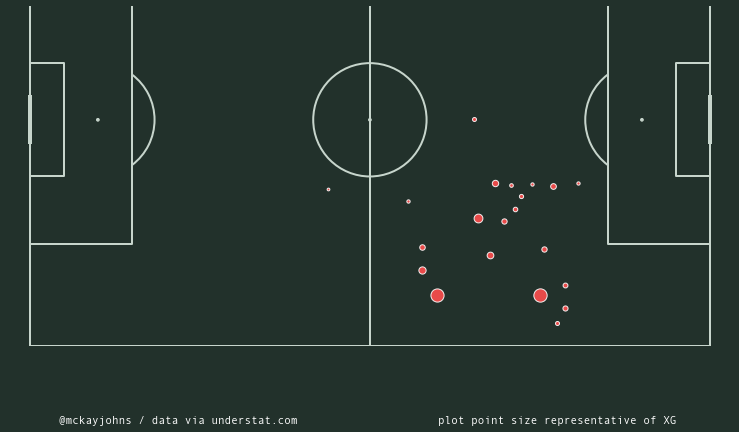

In [15]:
fig, ax = plt.subplots(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(13, 8),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.ylim(0,60)


plotShotMap()

fig.text(.18,.1,"@mckayjohns / data via understat.com",fontstyle='italic',fontsize=11,fontfamily='Andale Mono',color=text_color)
fig.text(.585,.1,'plot point size representative of XG',fontstyle='italic',fontsize=11,fontfamily='Andale Mono',color=text_color)

plt.savefig('testshotmap.png',dpi=300,bbox_inches = 'tight',facecolor=background)
